# Analyse predictions

In [1]:
from toolbox import *

import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

import random
import pickle
import glob
import os

In [2]:
import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")

## Load model predictions

In [3]:
gs = load_groundwater_station_data('./data/groundwater/bergstraße/gw_stations_bergstraße.csv')
gs = gs[['station_id', 'geometry']]
gs.head()

,station_id,geometry
0,12890,POINT (8.42892 49.70283)
1,12891,POINT (8.48631 49.70426)
2,12892,POINT (8.38953 49.70415)
3,12893,POINT (8.46023 49.70451)
4,12894,POINT (8.40465 49.70432)


In [4]:
pred_folder = './data/predictions'
past_data_path = './data/predictions/past_data.feather'
predictions = {}

# load predictions data
for path in glob.iglob(f'{pred_folder}/add*.feather'):
    pred_name = os.path.splitext(os.path.basename(path))[0]
    print(pred_name)#, path)
    p = pd.read_feather(path)
    p = pd.merge(p, gs, how='left', on='station_id')
    predictions[pred_name] = p

# load past data
past = pd.read_feather(past_data_path)
past = pd.merge(past, gs, how='left', on='station_id')
predictions['past_data'] = past

add_t+4_p+10
add_ref
add_t+4_p-10


In [5]:
past = predictions['past_data'].set_index('date')
pred = predictions['add_t+4_p-10'].set_index('date')
base = predictions['add_ref'].set_index('date')
#past = predictions['past_data'].set_index('date')
#pred = predictions['avg_t+4_p-10'].set_index('date')
#base = predictions['avg_t0_p0'].set_index('date')

In [6]:
past.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 424349 entries, 1971-01-04 to 2020-12-31
Data columns (total 27 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   station_id                  424349 non-null  int64   
 1   ground_elev                 424349 non-null  float64 
 2   x                           424349 non-null  float64 
 3   y                           424349 non-null  float64 
 4   reg_clusters                424349 non-null  float64 
 5   ini_years_water_depth_mean  424349 non-null  float64 
 6   ini_years_water_depth_std   424349 non-null  float64 
 7   ini_years_water_depth_min   424349 non-null  float64 
 8   ini_years_water_depth_max   424349 non-null  float64 
 9   precip_mean                 424349 non-null  float64 
 10  tmean_mean                  424349 non-null  float64 
 11  moisture_mean               424349 non-null  float64 
 12  precip_mean_prev_2d_sum     424349 non-nul

## Analyze predictions over time

Must be resampled because station data begins on different dates.

In [7]:
keep_cols = ['station_id',# 'geometry',
            'pred_water_depth',
             'tmean_mean',
             'precip_mean',
            'tmean_mean_prev_1y_mean',
            'precip_mean_prev_1y_sum']

past_weekly = past[keep_cols + ['water_depth']].groupby(by='station_id').resample('W').mean()
pred_weekly = pred[keep_cols].groupby(by='station_id').resample('W').mean()
base_weekly = base[keep_cols].groupby(by='station_id').resample('W').mean()

In [8]:
# delete nan rows of stations that did not cover the whole time period
#past_weekly[past_weekly.isna().any(axis=1)]
past_weekly = past_weekly.dropna()
pred_weekly = pred_weekly.dropna()
base_weekly = base_weekly.dropna()
#past_weekly

In [9]:
past_weekly.station_id = past_weekly.station_id.astype(int)
pred_weekly.station_id = pred_weekly.station_id.astype(int)
base_weekly.station_id = base_weekly.station_id.astype(int)

In [10]:
past_weekly = past_weekly.droplevel(0)
pred_weekly = pred_weekly.droplevel(0)
base_weekly = base_weekly.droplevel(0)

past_weekly['date'] = past_weekly.index
pred_weekly['date'] = pred_weekly.index
base_weekly['date'] = base_weekly.index

In [11]:
past_weekly = pd.merge(past_weekly, gs[['station_id', 'geometry']],
                       how='left', on='station_id')
pred_weekly = pd.merge(pred_weekly, gs[['station_id', 'geometry']],
                       how='left', on='station_id')
base_weekly = pd.merge(base_weekly, gs[['station_id', 'geometry']],
                       how='left', on='station_id')

In [12]:
# convert to geopandas
past_weekly = gpd.GeoDataFrame(past_weekly, geometry=past_weekly['geometry'], crs='EPSG:4326')
pred_weekly = gpd.GeoDataFrame(pred_weekly, geometry=pred_weekly['geometry'], crs='EPSG:4326')
base_weekly = gpd.GeoDataFrame(base_weekly, geometry=base_weekly['geometry'], crs='EPSG:4326')

In [13]:
#past_weekly

In [14]:
pred_weekly['base_water_depth'] = base_weekly['pred_water_depth']
pred_weekly['water_depth_anomaly'] = pred_weekly['pred_water_depth'] - pred_weekly['base_water_depth']

In [15]:
pred_weekly['water_depth_anomaly']

0         0.104930
1         0.032890
2         0.136584
3         0.010730
4         0.056545
            ...   
298915    0.260004
298916    0.228741
298917    0.168469
298918    0.142086
298919    0.216252
Name: water_depth_anomaly, Length: 298920, dtype: float64

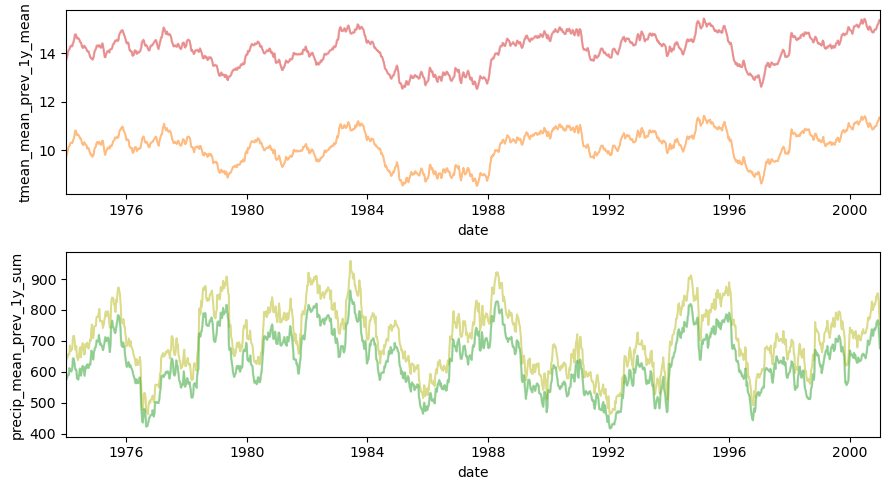

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(9,5))
sns.lineplot(data=past_weekly, x="date", y="tmean_mean_prev_1y_mean", 
             errorbar='sd', color='tab:orange', alpha=0.4, ax=axs[0])
sns.lineplot(data=pred_weekly, x="date", y="tmean_mean_prev_1y_mean", 
             errorbar='sd', color='tab:red', alpha=0.4, ax=axs[0])
axs[0].set_xlim(pd.to_datetime('1974'), pd.to_datetime('2001'))

sns.lineplot(data=past_weekly, x="date", y="precip_mean_prev_1y_sum", 
             errorbar='sd', color='tab:olive', alpha=0.4, ax=axs[1])
sns.lineplot(data=pred_weekly, x="date", y="precip_mean_prev_1y_sum", 
             errorbar='sd', color='tab:green', alpha=0.4, ax=axs[1])
axs[1].set_xlim(pd.to_datetime('1974'), pd.to_datetime('2001'))

plt.tight_layout()

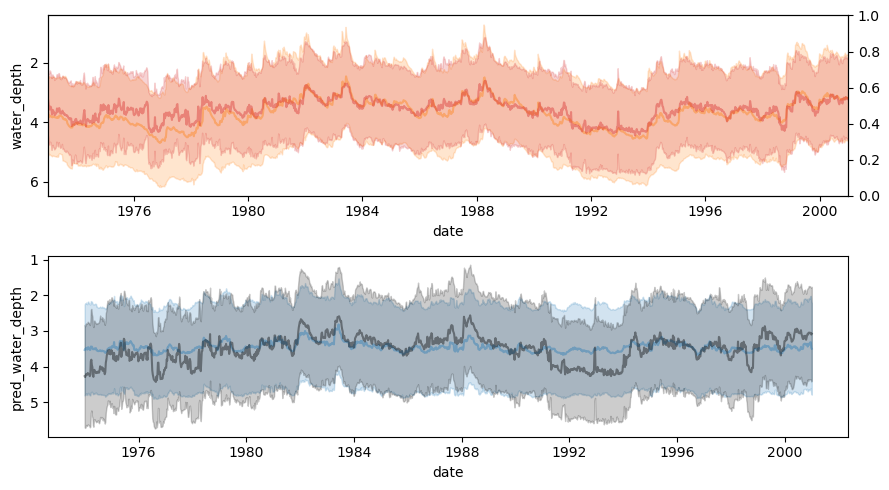

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(9,5))
for ax in axs:
    ax.invert_yaxis()

sns.lineplot(data=past_weekly, x="date", y="water_depth", 
             errorbar='sd', color='tab:orange', alpha=0.4, ax=axs[0])
sns.lineplot(data=past_weekly, x="date", y="pred_water_depth", 
             errorbar='sd', color='tab:red', alpha=0.4, ax=axs[0])
ax1_twin = axs[0].twinx()

sns.lineplot(data=pred_weekly, x="date", y="pred_water_depth", 
             errorbar='sd', color='tab:blue', alpha=0.4, ax=axs[1])
sns.lineplot(data=base_weekly, x="date", y="pred_water_depth", 
             errorbar='sd', color='k', alpha=0.4, ax=axs[1])
#ax.axhline(y=0, color='k', alpha=0.7)

plt.xlim(pd.to_datetime('1973'), pd.to_datetime('2001'))
plt.tight_layout()
plt.show()

<Axes: xlabel='date', ylabel='pred_water_depth'>

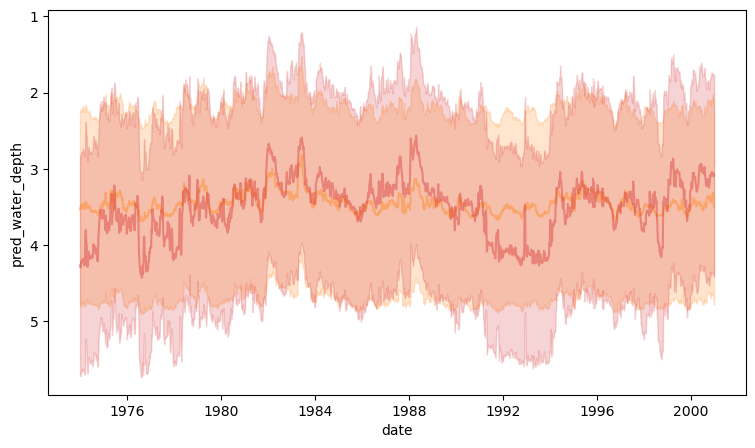

In [18]:
fig, ax = plt.subplots(figsize=(9,5))
ax.invert_yaxis()
sns.lineplot(data=pred_weekly, x="date", y="pred_water_depth", 
             errorbar='sd', color='tab:orange', alpha=0.4, ax=ax)
sns.lineplot(data=base_weekly, x="date", y="pred_water_depth", 
             errorbar='sd', color='tab:red', alpha=0.4, ax=ax)

### Anomalies for all stations
neg. anomaly = scenario predicts shallower water than in ref scenario

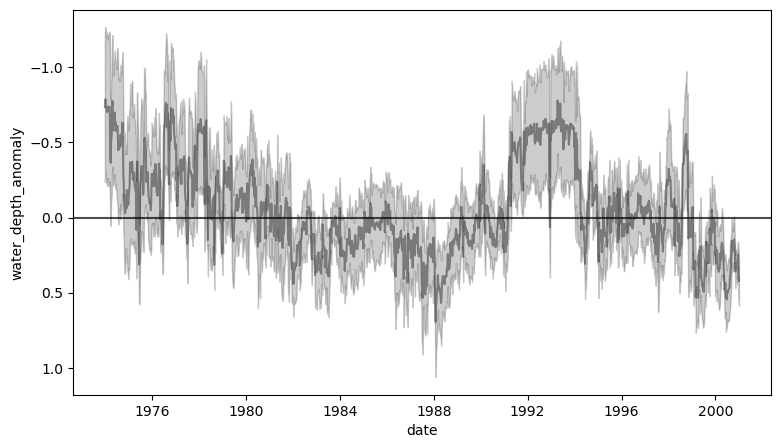

In [19]:
fig, ax = plt.subplots(figsize=(9,5))
ax.invert_yaxis()
sns.lineplot(data=pred_weekly, x="date", y="water_depth_anomaly", 
             errorbar='sd', color='k', alpha=0.4, ax=ax)
ax.axhline(y=0, color='k', alpha=0.7)

In [20]:
# Load hillshade DEM
dem, dem_extent = load_dem('./data/dem/bergstraße30_shaded.tif')

In [23]:
pred_weekly.loc[pred_weekly['date'] < pd.to_datetime('2000-10-29')].tail(10)

,station_id,pred_water_depth,tmean_mean,precip_mean,tmean_mean_prev_1y_mean,precip_mean_prev_1y_sum,date,geometry,base_water_depth,water_depth_anomaly
298900,17794,3.453322,26.174286,0.684000,15.060611,687.857143,2000-08-20,POINT (8.57042 49.78242),3.275691,0.177631
298901,17794,3.414344,22.814286,2.028857,15.100650,694.324286,2000-08-27,POINT (8.57042 49.78242),3.374068,0.040277
298902,17794,3.414344,20.308571,1.686857,15.082247,702.051429,2000-09-03,POINT (8.57042 49.78242),3.393304,0.021040
298903,17794,3.420907,19.022857,1.792286,14.999288,717.510857,2000-09-10,POINT (8.57042 49.78242),3.401827,0.019080
298904,17794,3.420907,21.105714,3.808286,14.935632,730.059429,2000-09-17,POINT (8.57042 49.78242),3.327717,0.093190
298905,17794,3.420907,17.711429,0.678857,14.885691,737.812286,2000-09-24,POINT (8.57042 49.78242),3.408153,0.012755
298906,17794,3.420907,19.700000,2.674286,14.852360,717.840000,2000-10-01,POINT (8.57042 49.78242),3.326920,0.093988
298907,17794,3.420907,14.982857,1.524857,14.887523,716.508000,2000-10-08,POINT (8.57042 49.78242),3.414001,0.006907
298908,17794,3.444045,14.794286,2.229429,14.866497,735.626571,2000-10-15,POINT (8.57042 49.78242),3.437244,0.006801
298909,17794,3.420907,15.085714,0.527143,14.946865,739.787143,2000-10-22,POINT (8.57042 49.78242),3.352780,0.068128


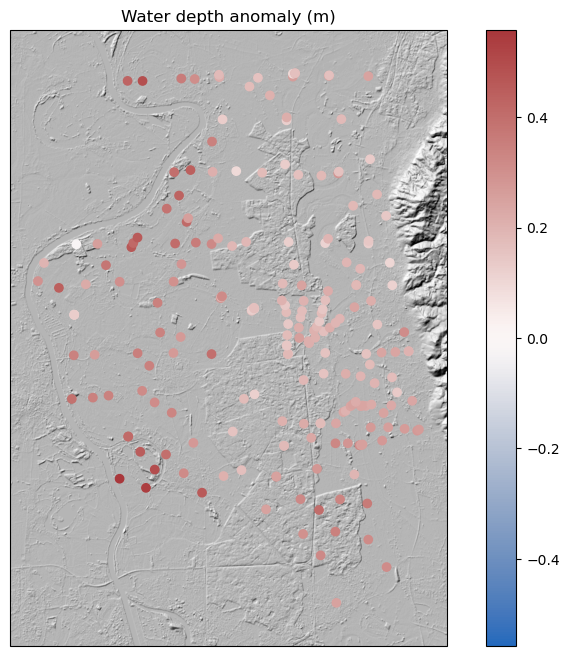

In [24]:
extent = pred_weekly.geometry.total_bounds

data = pred_weekly.loc[pred_weekly['date'] == pd.to_datetime('2000-10-29')]
cmap = 'vlag'

# Create a figure and axis with a PlateCarree projection
fig, ax = plt.subplots(figsize=(10, 8), 
                       subplot_kw={'projection': ccrs.PlateCarree()} # removes axis labels
                      )

# Plot hillshade DEM
ax.imshow(dem, extent=(dem_extent[0], dem_extent[2],
                       dem_extent[1], dem_extent[3]),
          cmap='gray', origin='upper', aspect='auto')

data.plot(column='water_depth_anomaly',
            cmap=cmap, norm=colors.CenteredNorm(),
            legend=True, 
            ax=ax)

ax.set_xlim(extent[0]-0.02, extent[2]+0.02)
ax.set_ylim(extent[1]-0.02, extent[3]+0.02)

#ax.legend(loc='lower left', framealpha=0.5)

plt.title('Water depth anomaly (m)')
#plt.savefig('./figs/map_mean_water_depth_all_stations.png', bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
import plotly.graph_objects as go
import nbformat
print(nbformat.__version__)

In [ ]:
# Create a figure
fig = go.Figure()

# Add a trace for the entire dataset
fig.add_trace(go.Scatter(x=pred_weekly['date'], y=pred_weekly['water_depth_anomaly'],
                         mode='lines', name='Value'))

# Create a slider for date selection
steps = []
for date in pred_weekly['date'].unique():
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)},
              {"title": "Date: " + str(date)}],
        label=str(date)
    )
    step["args"][0]["visible"][0] = True # Make the first trace visible
    steps.append(step)

sliders = [dict(
    active=0,
    currentvalue={"prefix": "Date: "},
    pad={"t": 50},
    steps=steps
)]

# Update layout to include sliders
fig.update_layout(
    sliders=sliders
)

# Show the figure
fig.show()